<a href="https://colab.research.google.com/github/Skaveza/Summative_System_Deployment/blob/main/Summative_System_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook demonstrates the retraining of optimized_model_nn3 using the original dataset, as it previously achieved the highest accuracy. To further improve performance, hyperparameter tuning and class weight balancing are applied.**

1. Mount Drive and Import Dependecies

In [ ]:
from google.colab import drive
import sys
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2

# Mount Google Drive
drive.mount('/content/drive')

# Add path to access preprocessing functions
sys.path.append('/content/drive/MyDrive')
from preprocessing_code import validate_and_preprocess, prepare_training_data

print("Functions imported successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Functions imported successfully!


2.Load Dataset and Pre-process

In [ ]:
# Load dataset from Hugging Face storage or Drive
data_path = "hf://datasets/Pollicy/Uganda_HealthCare_Facilities/Full collected hospital data 6K+ - All healthcare facilities.csv"
df = pd.read_csv(data_path)

# Preprocess data using the same functions
print("Preprocessing data...")
validated_data, _ = validate_and_preprocess(df)
prep_result = prepare_training_data(validated_data)

# Extract processed features and labels
X_resampled = prep_result['X_resampled']
y_resampled = prep_result['y_resampled']
preprocessors = prep_result['preprocessors']


Preprocessing data...
Preprocessors saved successfully at: /content/drive/MyDrive/saved_preprocessors/preprocessors_latest.pkl


3.Split Data for Training, Validation and Testing

In [ ]:
# Splitting resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print dataset shapes
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 10188 samples, 1701 features
Validation set: 3396 samples
Test set: 3396 samples


4.Define Class Weights


In [ ]:
def get_class_weights(y_one_hot):
    """
    Compute class weights for a one-hot encoded target variable.
    Converts one-hot encoded labels to categorical class labels.
    """
    y_categorical = np.argmax(y_one_hot, axis=1)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_categorical),
        y=y_categorical
    )
    return dict(enumerate(class_weights))

 #Compute class weights with fixed function
class_weights = get_class_weights(y_train)

print("Class weights computed successfully:", class_weights)



Class weights computed successfully: {0: np.float64(1.0086130086130085), 1: np.float64(0.988646288209607), 2: np.float64(1.0029533372711164)}


5. Load and Retrain the Model

In [ ]:
# Path to saved model
model_path = "/content/drive/MyDrive/saved_models/optimized_nn3_model.keras"

# Load model architecture
model = load_model(model_path)

# Compile model again for training
lr_schedule = ExponentialDecay(initial_learning_rate=0.0005, decay_steps=1000, decay_rate=0.9, staircase=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping to prevent overfitting
callbacks = [EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]

# Train model on new data
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("Model retraining completed successfully!")


Epoch 1/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.7428 - loss: 0.9580 - val_accuracy: 0.7977 - val_loss: 0.8966
Epoch 2/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.7627 - loss: 1.0225 - val_accuracy: 0.8148 - val_loss: 0.9135
Epoch 3/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7728 - loss: 1.0207 - val_accuracy: 0.8274 - val_loss: 0.8941
Epoch 4/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7878 - loss: 0.9951 - val_accuracy: 0.8316 - val_loss: 0.8707
Epoch 5/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7977 - loss: 0.9612 - val_accuracy: 0.8363 - val_loss: 0.8563
Epoch 6/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8032 - loss: 0.9158 - val_accuracy: 0.8342 - val_loss: 0.8291
Epoch 7/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.8025 - loss: 0.9105 - val_accuracy: 0.8363 - val_loss: 0.7897
Epoch 8/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8112 - loss: 0.8625 - 

Model Evaluation

In [ ]:
print("\nEvaluating the model on the test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Display final test accuracy
print(f"\nUpdated Test Accuracy: {test_accuracy:.2f}")
print(f"Updated Test Loss: {test_loss:.2f}")



Evaluating the model on the test set...
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8809 - loss: 0.4162

Updated Test Accuracy: 0.88
Updated Test Loss: 0.42


In [ ]:
from sklearn.metrics import classification_report
import numpy as np


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_test_classes = np.argmax(y_test, axis=1)

# Step 3: Generate the classification report
report = classification_report(y_test_classes, y_pred_classes)
print(report)

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1148
           1       0.86      0.96      0.90      1120
           2       0.86      0.87      0.87      1128

    accuracy                           0.88      3396
   macro avg       0.88      0.88      0.88      3396
weighted avg       0.88      0.88      0.88      3396



Plot Training Loss

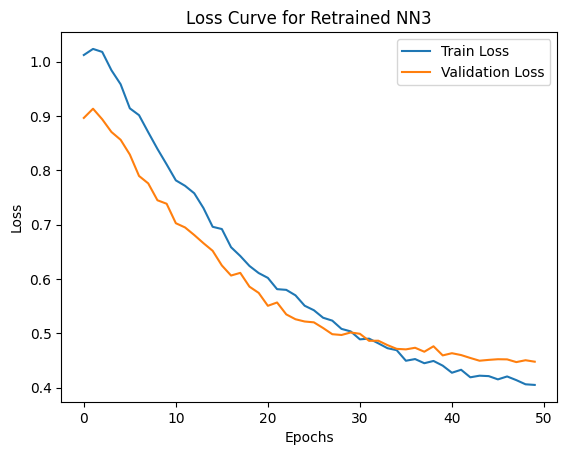

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve for Retrained NN3')
plt.legend()
plt.show()


Saving Model

In [ ]:
import tensorflow as tf
# Save retrained model
model.save("/content/drive/MyDrive/saved_models/healthcare_precict.h5")

# Save preprocessors
joblib.dump(preprocessors, "/content/drive/MyDrive/saved_preprocessors/preprocessors_latest.pkl")

print("Retrained model and preprocessors saved successfully!")


Retrained model and preprocessors saved successfully!


In [ ]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import joblib
from warnings import simplefilter
from tensorflow.keras.models import load_model
from preprocessing_code import prepare_prediction_data

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Step 2: Load Model & Preprocessors
model_path = "/content/drive/MyDrive/saved_models/healthcare_precict.h5"
preprocessor_path = "/content/drive/MyDrive/saved_preprocessors/preprocessors_latest.pkl"

# Load model and preprocessing objects
model = load_model(model_path)
with open(preprocessor_path, "rb") as preprocessor_file:
    preprocessors = joblib.load(preprocessor_file)

print("Model and preprocessors loaded successfully.")

# Step 3: Define New Data for Prediction
new_data = pd.DataFrame([{
    'services': 'X-ray, lab tests',
    'operating_hours': '9am-5pm',
    'care_system': 'Public',
    'mode of payment': 'Insurance',
    'Subcounty': 'Abia Subcounty',
    'latitude': 1.2345,
    'longitude': 36.789
}])

try:
    # Step 4: Preprocess Input Data
    X_pred = prepare_prediction_data(new_data, preprocessors)

    # Step 5: Make Prediction
    prediction_probs = model.predict(X_pred)

    # Step 6: Convert Probabilities to Class Indices
    predicted_class_index = np.argmax(prediction_probs, axis=1)

    # Step 7: Convert Class Index to Label
    label_encoder = preprocessors['label_encoder']
    predicted_label = label_encoder.inverse_transform(predicted_class_index)[0]

    # Step 8: Print Final Prediction Result
    print(f"Predicted Healthcare Facility Rating: {predicted_label}")

except Exception as e:
    print(f"Prediction failed: {e}")


Model and preprocessors loaded successfully.
Total feature names: 1701
Unique feature names: 1701
Columns in X before reindexing: 1501
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Predicted Healthcare Facility Rating: High
